In [7]:
# Import from the new modular structure
from reward import (
    create_four_optima_reward_landscape,
    four_optima_reward_gradient
)

from visualization import (
    visualize_base_model_distribution,
    visualize_step,
    visualize_gamma_and_diversity
)

from main_pairwise import (
    budget_constrained_diffusion_pairwise
)

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np

# Set random seed for reproducibility
jax.config.update("jax_enable_x64", True)

In [8]:
# Experiment parameters
k_observe = 50  # Number of pairs per step
B = 500  # Total budget (each pair costs 2 observations, so ~5 steps)
n_particles = 200
n_steps = 100

# Use four optima reward function
reward_function_4optima = create_four_optima_reward_landscape

print("="*80)
print("FKC PAIRWISE PREFERENCE LEARNING EXPERIMENT")
print("="*80)
print(f"Budget: {B} observations")
print(f"Pairs per step: {k_observe}")
print(f"Observations per step: {k_observe * 2}")
print(f"Expected steps: ~{B // (k_observe * 2)}")
print(f"Particles per step: {n_particles}")
print(f"Diffusion steps: {n_steps}")
print("="*80)

FKC PAIRWISE PREFERENCE LEARNING EXPERIMENT
Budget: 500 observations
Pairs per step: 50
Observations per step: 100
Expected steps: ~5
Particles per step: 200
Diffusion steps: 100


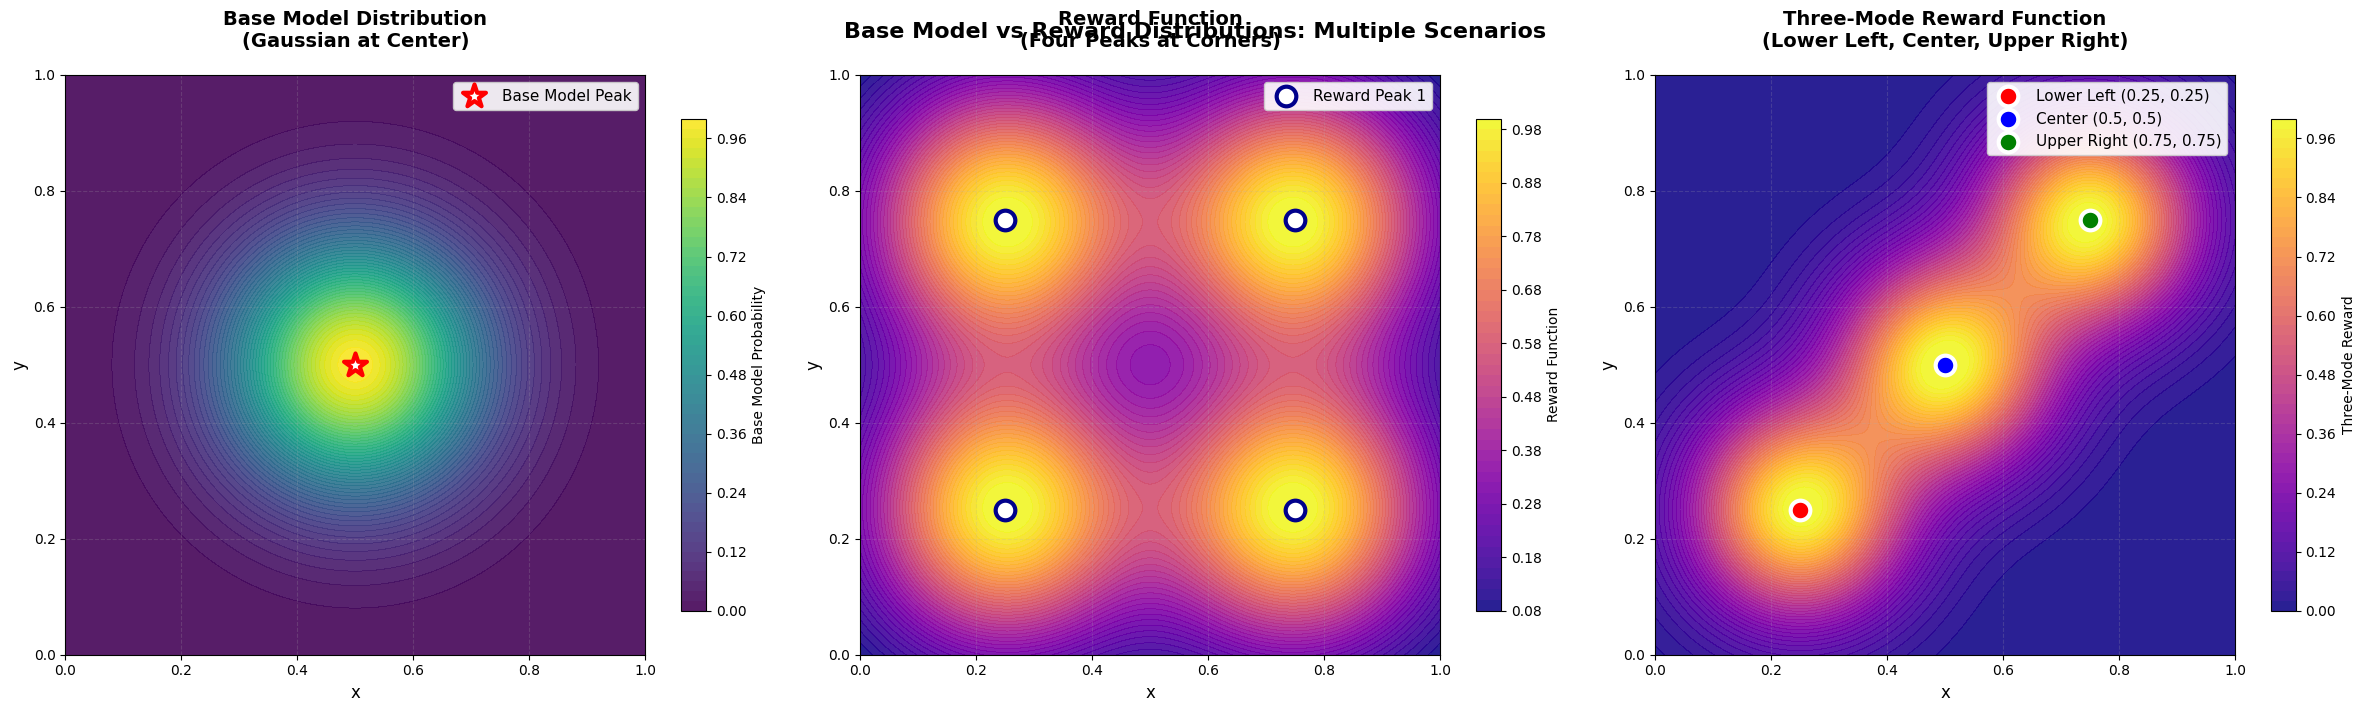

BASE MODEL vs REWARD DISTRIBUTIONS
Base Model: Gaussian at (0.5,0.5), σ=0.15
Four-Quadrant Reward: 4 peaks at corners (0.25,0.25), (0.75,0.25), (0.25,0.75), (0.75,0.75)
Three-Mode Reward: 3 peaks at (0.25,0.25), (0.5,0.5), (0.75,0.75)
TESTING: Pairwise Preference Learning (RLHF-style)

Base model: Gaussian peak at CENTER (0.5, 0.5)
Reward function: Four peaks at CORNERS (0.25, 0.25), etc.
Learning method: Bradley-Terry loss on pairwise comparisons



In [9]:
# VISUALIZE THE BASE MODEL DISTRIBUTION FIRST
visualize_base_model_distribution()

print("="*80)
print("TESTING: Pairwise Preference Learning (RLHF-style)")
print("="*80 + "\n")

print("Base model: Gaussian peak at CENTER (0.5, 0.5)")
print("Reward function: Four peaks at CORNERS (0.25, 0.25), etc.")
print("Learning method: Bradley-Terry loss on pairwise comparisons")
print("="*80 + "\n")

Starting FKC Pairwise Preference Learning...
  Created new preference learning network
Step 0 [COLD START], Budget remaining: 500
  Training preference network on 50 pairs
    Loss: 0.2337


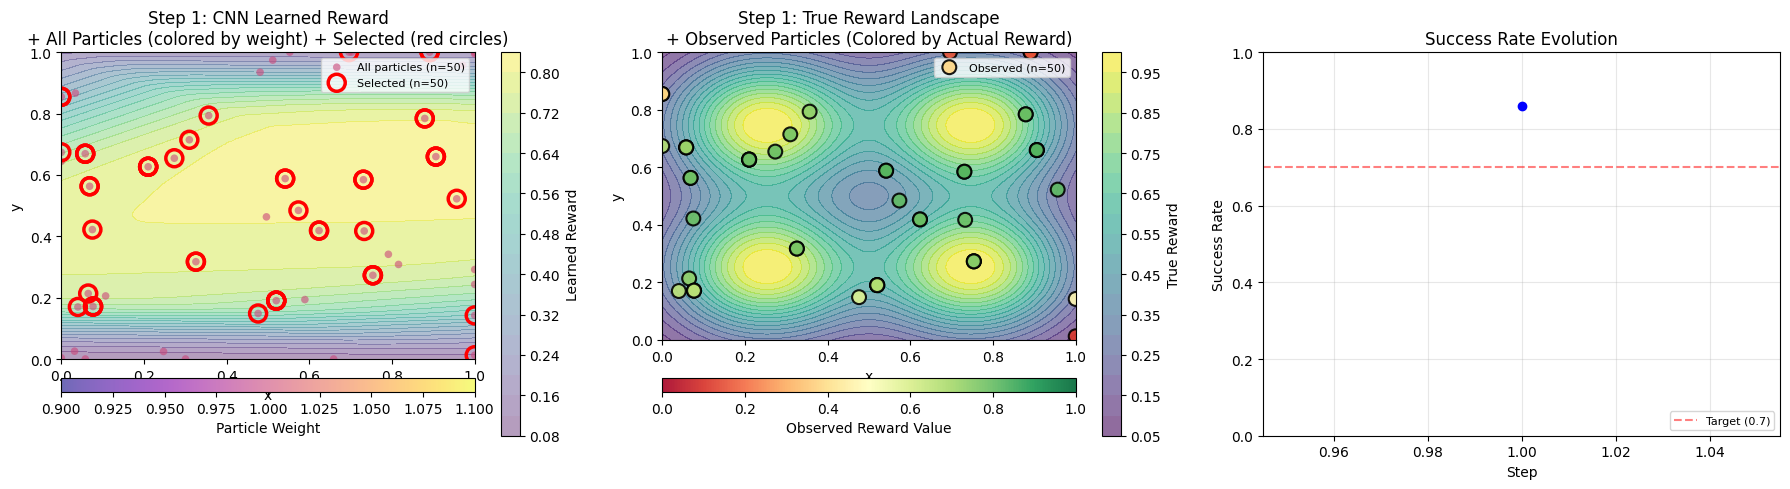

Step 1: 33/50 success (86.0%) | Avg: 0.685
Step 1, Budget remaining: 400
  *** DIVERSITY DISABLED: Converged ***
  Gamma: 0.050 | Diversity: False
  Historical particles: 50
    Weight range: [0.00, 1.00] | Selected: [0.97, 1.00]
  Training preference network on 100 pairs...
    Loss: 0.2538


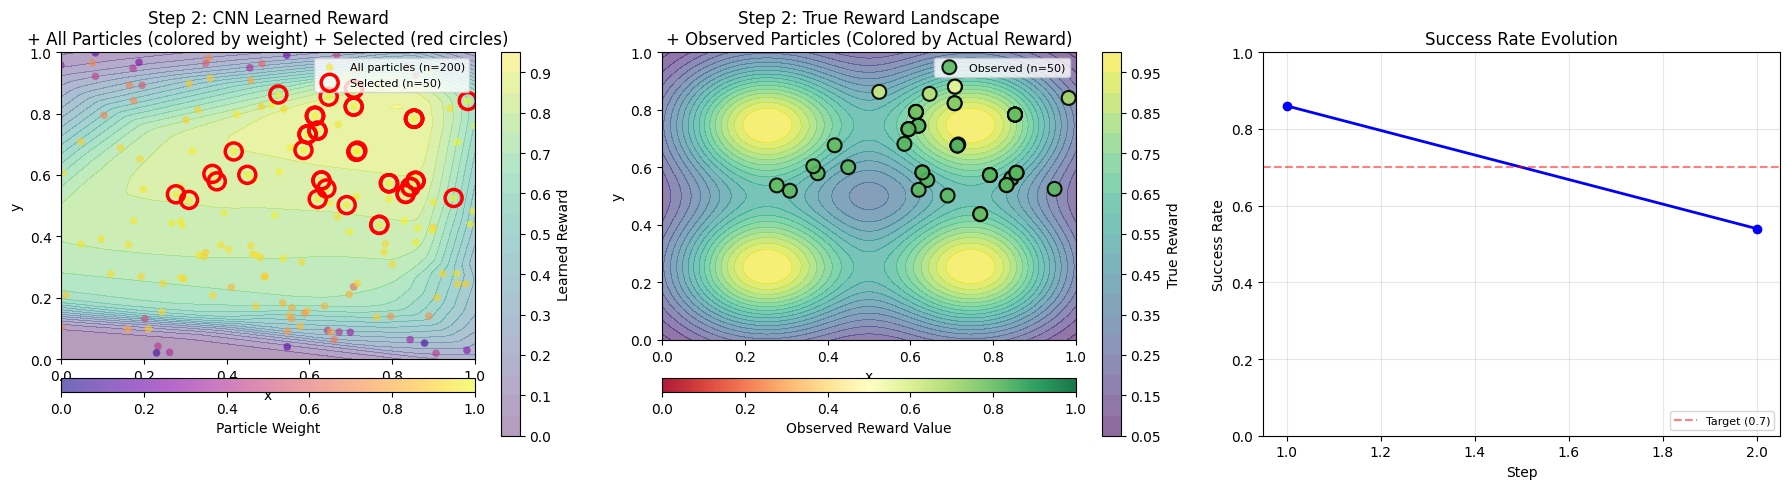

Step 2: 45/50 success (54.0%) | Avg: 0.788
Step 2, Budget remaining: 300
  Gamma: 0.038 | Diversity: False
  Historical particles: 100
    Weight range: [0.00, 1.00] | Selected: [0.88, 1.00]
  Training preference network on 150 pairs...
    Loss: 0.2179


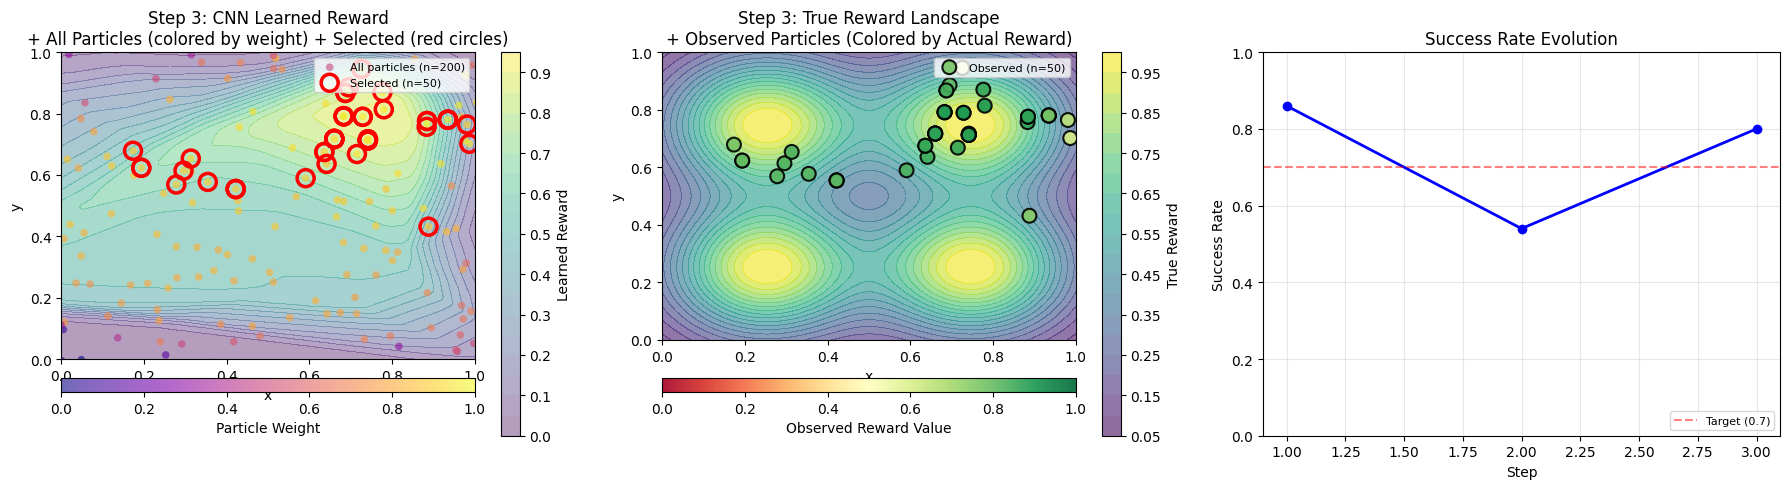

Step 3: 46/50 success (80.0%) | Avg: 0.826
Step 3, Budget remaining: 200
  Gamma: 0.025 | Diversity: False
  Historical particles: 150
    Weight range: [0.00, 1.00] | Selected: [0.62, 1.00]
  Training preference network on 200 pairs...
    Loss: 0.1821


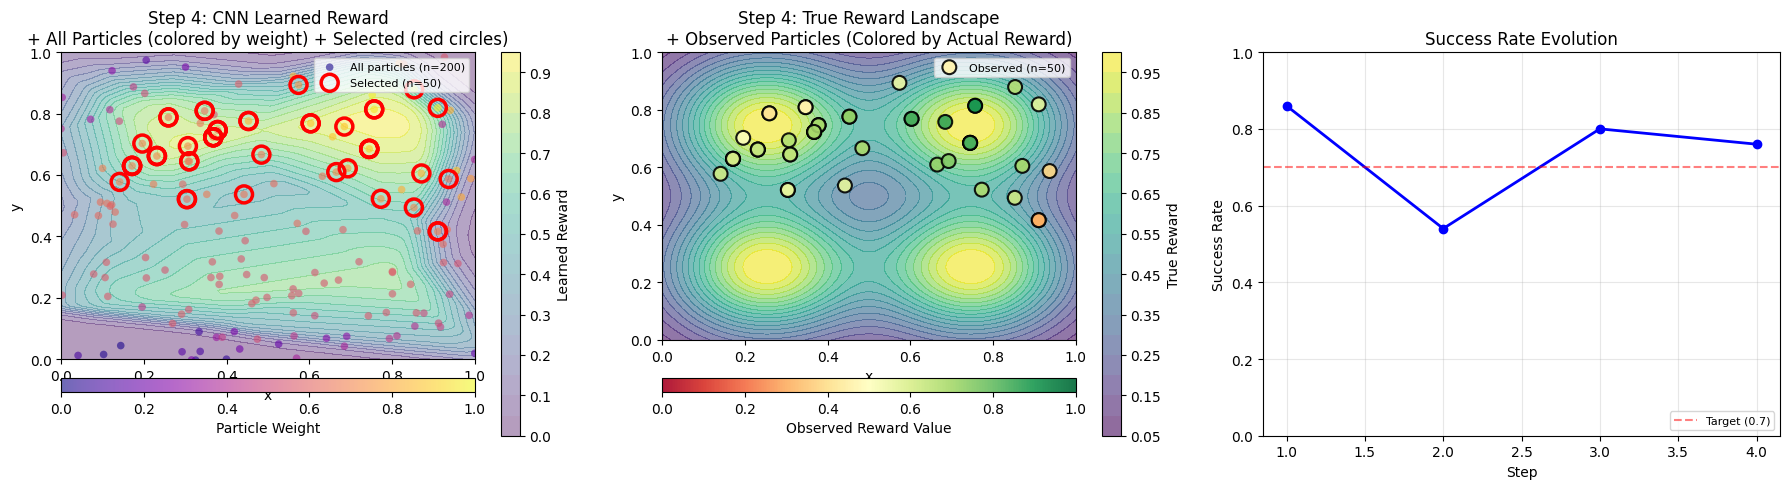

Step 4: 13/50 success (76.0%) | Avg: 0.650
Step 4, Budget remaining: 100
  Gamma: 0.013 | Diversity: False
  Historical particles: 200
    Weight range: [0.00, 1.00] | Selected: [0.70, 1.00]
  Training preference network on 250 pairs...
    Loss: 0.1467


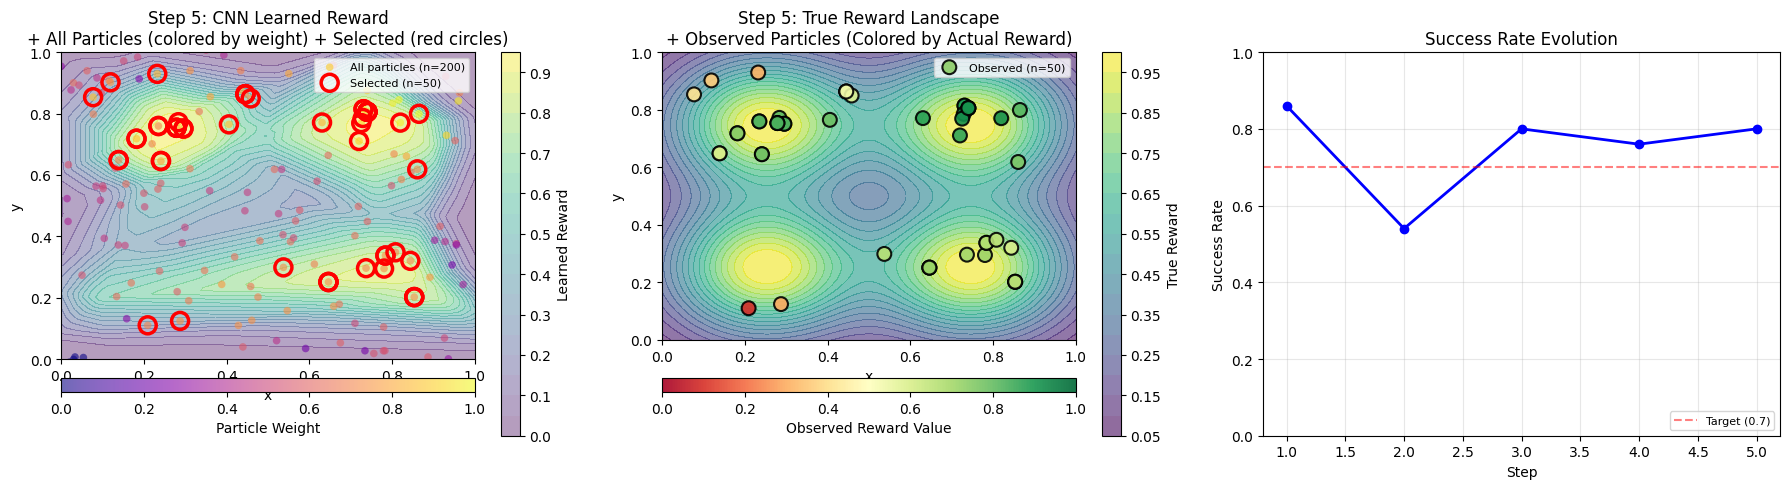

Step 5: 31/50 success (80.0%) | Avg: 0.714
EXPERIMENT COMPLETED


In [10]:
# Run with pairwise preference learning
print("Starting FKC Pairwise Preference Learning...")
print("="*80)

results = budget_constrained_diffusion_pairwise(
    k_observe=k_observe, 
    B=B, 
    n_particles=n_particles,
    n_steps=n_steps,
    reward_fn=reward_function_4optima
)

# Unpack results
(all_particles, all_weights, all_pairs, all_winners, all_losers,
 success_rates, trained_network, trained_params, trained_opt_state, 
 gamma_history) = results

print("="*80)
print("EXPERIMENT COMPLETED")
print("="*80)


DIVERSITY-BASED EXPLORATION VISUALIZATION



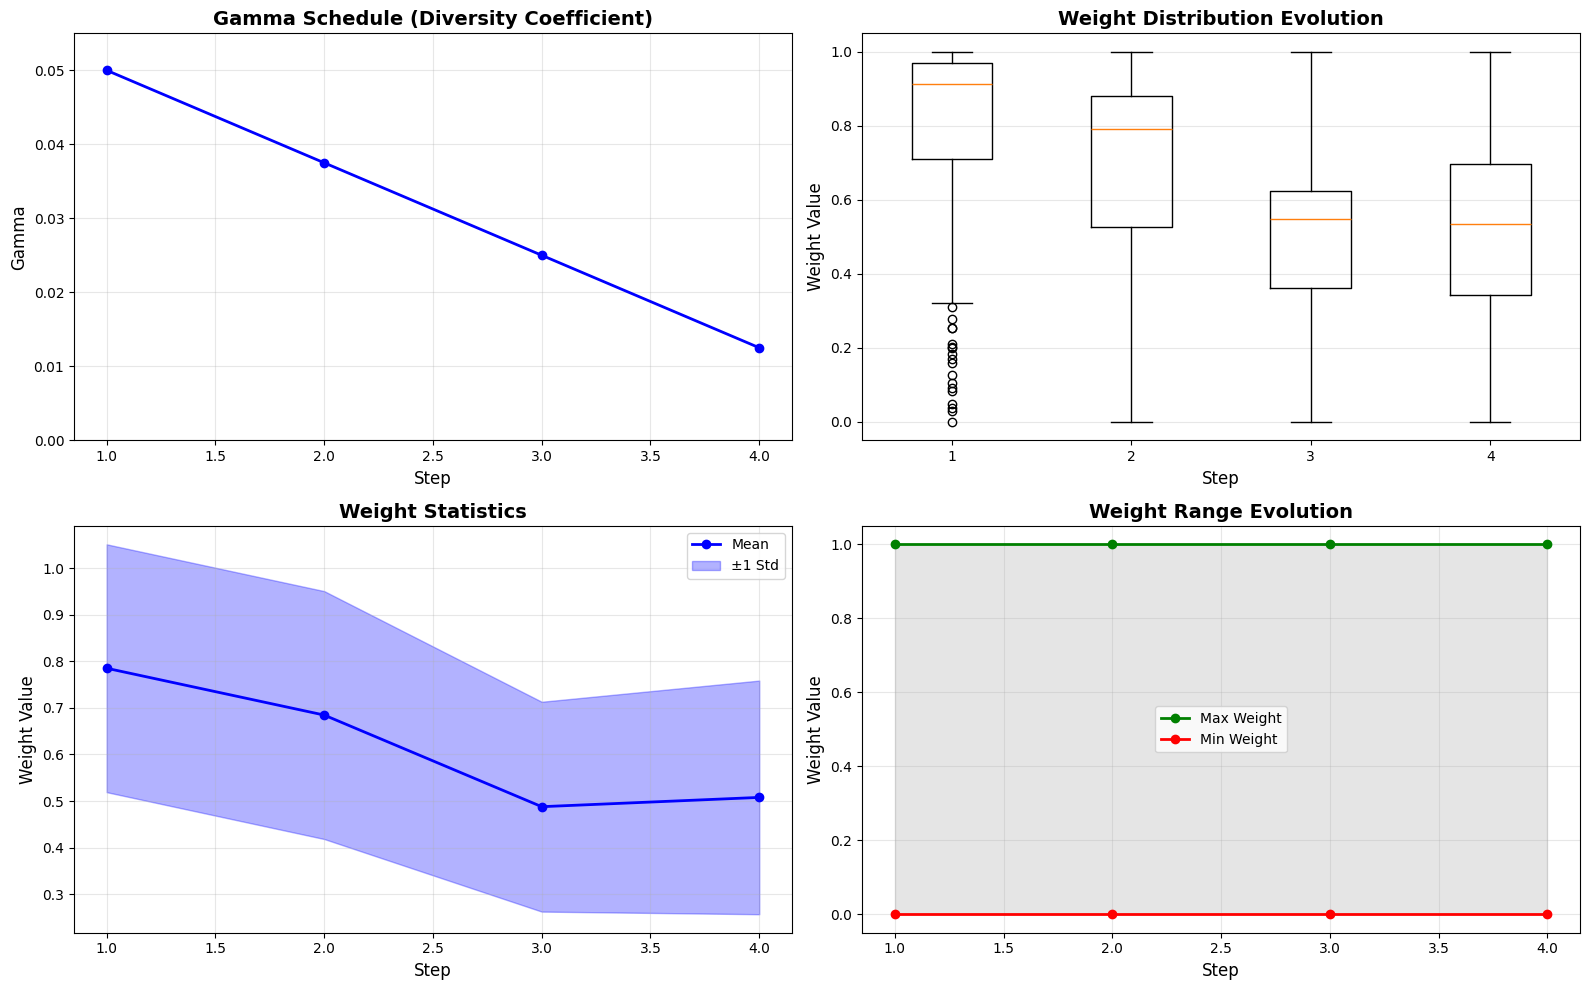


EXPERIMENT SUMMARY
Steps: 4 | Gamma: 0.013→0.050
Selection: top-50 particles | Final gamma: 0.013


In [11]:
# Visualize diversity-based behavior
print("\n" + "="*80)
print("DIVERSITY-BASED EXPLORATION VISUALIZATION")
print("="*80 + "\n")
visualize_gamma_and_diversity(gamma_history, all_weights, k_observe)

In [12]:
# Final analysis
print("\n" + "="*80)
print("FINAL ANALYSIS")
print("="*80)
print(f"Final success rate: {success_rates[-1]:.1%}")
print(f"Max success rate achieved: {max(success_rates):.1%}")
print(f"Average success rate: {np.mean(success_rates):.1%}")

# Additional statistics
print(f"\nTotal steps: {len(success_rates)}")
print(f"Total pairs observed: {sum(len(pairs) for pairs in all_pairs)}")
print(f"Total observations used: {sum(len(pairs) * 2 for pairs in all_pairs)}")
print(f"Budget used: {B - (B % (k_observe * 2))}")

# Preference statistics
all_winners_concat = jnp.concatenate(all_winners, axis=0)
all_losers_concat = jnp.concatenate(all_losers, axis=0)
winner_true_rewards = reward_function_4optima(all_winners_concat)
loser_true_rewards = reward_function_4optima(all_losers_concat)

print(f"\nPairwise Comparison Statistics:")
print(f"Winners - Mean true reward: {np.mean(winner_true_rewards):.3f}")
print(f"Losers  - Mean true reward: {np.mean(loser_true_rewards):.3f}")
print(f"Mean difference: {np.mean(winner_true_rewards - loser_true_rewards):.3f}")

# Check if diversity was disabled
diversity_disabled_step = None
for i, gamma in enumerate(gamma_history):
    if gamma == 0.0:
        diversity_disabled_step = i + 1
        break

if diversity_disabled_step:
    print(f"\nDiversity disabled at step: {diversity_disabled_step}")
else:
    print("\nDiversity remained enabled throughout experiment")


FINAL ANALYSIS
Final success rate: 80.0%
Max success rate achieved: 86.0%
Average success rate: 75.2%

Total steps: 5
Total pairs observed: 250
Total observations used: 500
Budget used: 500

Pairwise Comparison Statistics:
Winners - Mean true reward: 0.688
Losers  - Mean true reward: 0.434
Mean difference: 0.254

Diversity remained enabled throughout experiment
